# 1) Tide Revisited with internal ML

## a) Data Preprocessing

In [ ]:
import pandas as pd
from klines_managers import klines_ccxt

timeframe_to_trade = "1h"


instruments =  ["ccxt_kucoin__BTC-USDT",
                 "ccxt_currencycom__US500",
                 "ccxt_currencycom__DXY",
                 "ccxt_currencycom__Gold",
                 "ccxt_currencycom__Oil - Crude",
                  "ccxt_currencycom__NVDA",
                   "ccxt_currencycom__UVXY" ]
timeframes = ["1h"]

kline_manager = klines_ccxt.KlinesManagerCCXT()
klines_dict = kline_manager.load_ohlcvs(instruments = instruments,
                                        timeframes = timeframes,
                                        since = "2019-01-01 00:00:00",
                                        limit = 1000, update=False)


# Resample from 1hr --> 2h, 3h, 4h, 6h, 12h, 24h, 
from signal_managers import resampler
from signal_managers import indicators

resample_to_list = ["2h", "3h", "4h", "6h", "12h", "24h"]
first_timeframe = "1h"

print(klines_dict.keys())
print(klines_dict['ccxt_kucoin__BTC-USDT'].keys())
# resample_to_list = ["15m", "20m", "30m", "60m"]
# first_timeframe = "5m"
for instrument,instrument_dict in klines_dict.items():
    # print(f"\n{instrument}\n")
    for resample_to in resample_to_list:
        df = instrument_dict[first_timeframe].copy()
        window = int(int(resample_to[:-1])/int(first_timeframe[:-1]))
        # print(f"Resampling {first_timeframe} to {resample_to} --> window: {window}")
        if "m" in resample_to:
            resample_to_formatted = resample_to[:-1]+"T"
        else:
            resample_to_formatted = resample_to
        df_resampled = resampler.calc_klines_resample(df,window=window, resample_to=resample_to_formatted)
        # print(df_resampled.columns)
        klines_dict[instrument][resample_to] = df_resampled


from signal_managers.indicators import calc_tide_strengths
from signal_managers import tide_genetic

print(klines_dict.keys())
print(klines_dict['ccxt_kucoin__BTC-USDT'].keys())
# generate tides for each instruments
instrument_to_trade = "ccxt_kucoin__BTC-USDT"
timeframe_to_trade = "1h"
for instrument in klines_dict.keys():
    for timeframe in klines_dict[list(klines_dict.keys())[0]]:
        timeframe_multiplier = int(timeframe[:-1])/int(timeframe_to_trade[:-1])
        df = klines_dict[instrument][timeframe]
        df = indicators.calc_tides(df,suffix="")
        df = indicators.calc_z_sig(df,cols=['open','high','low','close'], lookback_bars = 24*timeframe_multiplier, threshold = [])
        df=df.dropna()
        from signal_managers import tide_genetic

        # Initialise parent
        tp_position_list = tide_genetic.init_tp_position_parameter_population()
        df0 = tide_genetic.initialise_parent(df)
        df0 = calc_tide_strengths(df0, penalty = 1, tp_position_dict = tp_position_list[0])
        features = ['tide', 'ebb', 'flow', 'sig'] + list(df0.copy().filter(regex="tide").columns)[:-1]
        features = list(set(features))

        tide_parameters_to_test = {"sensitivity":40,
                                "threshold":10,
                                    "windows":[24,36,72],
                                    "SL_penalty":1,
                                    "TPs": tp_position_list[0],
                                }
        sharpe_df, best_df, best_parameter, best_sharpe = tide_genetic.evaluate_population(df0,parameters = tide_parameters_to_test, generations=10)
        # Perform genetic propagation
        best_df[features] = best_df[features].copy().fillna(method='ffill').dropna()
        klines_dict[instrument][timeframe] = best_df
        
        # Join into one DF
        if instrument == instrument_to_trade and timeframe == timeframe_to_trade:
            df_trade = best_df.copy() 

        else:
            df["sharpe"] = best_sharpe["sharpe"].iloc[0]
            df_trade = pd.merge(df_trade, best_df[features].add_prefix(f"{timeframe}_{instrument.split('__')[-1]}_"), left_index=True, right_index=True, how="left")
    


## a) Tide_Z signal V3

In [1]:
import pandas as pd
from klines_managers import klines_ccxt

timeframe_to_trade = "1h"


instruments =  ["ccxt_kucoin__BTC-USDT",
                 "ccxt_currencycom__US500",
                 "ccxt_currencycom__DXY",
                 "ccxt_currencycom__Gold",
                 "ccxt_currencycom__Oil - Crude",
                  "ccxt_currencycom__NVDA",
                   "ccxt_currencycom__UVXY"]
timeframes = ["1h"]

kline_manager = klines_ccxt.KlinesManagerCCXT()
klines_dict = kline_manager.load_ohlcvs(instruments = instruments,
                                        timeframes = timeframes,
                                        since = "2018-01-01 00:00:00",
                                        limit = 1000, update=False, verbose=False)

df = klines_dict["ccxt_kucoin__BTC-USDT"]["1h"]#.copy() but memwasteful since can just reload the klines again

In [4]:
from signal_managers.indicators import calc_tide_sig
import numpy as np
def dynamic_params_func(x, i):
    # Calculate the volatility of the input data
    volatility = np.std(x[:i,-1]) # This is too smooth to be vol triggers have to change for future use
    
    # Set the window lengths and threshold values based on the volatility
    if volatility < 0.01:
        windows = [[288, 576]]
        thresholds = [1.5, 2.0, 2.5]
    elif volatility < 0.05:
        windows = [[144, 288]]
        thresholds = [1.0, 1.5, 2.0]
    else:
        windows = [[72, 144]]
        thresholds = [0.5, 1.0, 1.5]
    
    return windows, thresholds, [50]

def dynamic_params_func1(x, i):
    """
    Template for dynamic parameters function
    where x is a np_array of cols + dynamic_param_col
    """
    window_lengths = [[5, 20, 67]]
    thresholds = [0.1]
    sensitivity = [50]
    return window_lengths, thresholds, sensitivity

df1= df.copy()
df2 = calc_tide_sig(df1,
                    cols_set=[['open','high','low']],
                     tide_window_threshold_func= dynamic_params_func,
                     dynamic_param_col = ["volume"])

  0%|          | 0/1 [00:00<?, ?it/s]d:\PycharmProjects\quant_experiments\venv\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\PycharmProjects\quant_experiments\venv\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\PycharmProjects\quant_experiments\venv\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  0%|          | 0/1 [00:00<?, ?it/s]


IndexError: index 1 is out of bounds for axis 0 with size 1

In [3]:
df2

,open,high,low,close,volume,close_time,tide_w5-20-67t0.1,ebb_w5-20-67t0.1,flow_w5-20-67t0.1
datetime,,,,,,,,,
2018-11-25 16:00:00,3886.678607,3903.648904,3835.158247,3875.647378,24.080719,1.543162e+09,NaN,NaN,NaN
2018-11-25 17:00:00,3882.521407,3891.388154,3816.986907,3849.141652,21.726807,1.543165e+09,NaN,NaN,NaN
2018-11-25 18:00:00,3859.873602,3895.840831,3842.289291,3873.965860,10.762191,1.543169e+09,NaN,NaN,NaN
2018-11-25 19:00:00,3864.252323,4019.285405,3858.893570,3924.100347,50.699665,1.543172e+09,NaN,NaN,NaN
2018-11-25 20:00:00,3935.724843,4163.629852,3913.719395,4064.823624,87.334735,1.543176e+09,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-08-21 02:00:00,26146.200000,26159.700000,26079.300000,26096.700000,30.048178,1.692583e+09,0.0,26166.4,26178.7
2023-08-21 03:00:00,26096.700000,26108.800000,26072.000000,26091.400000,15.693983,1.692587e+09,0.0,26159.7,26166.4
2023-08-21 04:00:00,26091.500000,26091.500000,26041.600000,26058.800000,51.110190,1.692590e+09,0.0,26108.8,26159.7


<Axes: xlabel='datetime'>

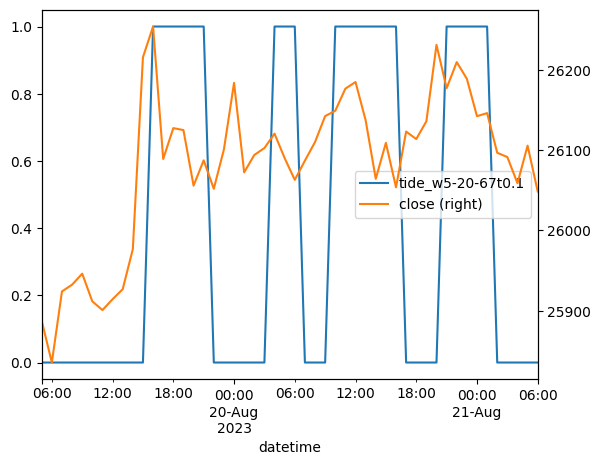

In [6]:
df2[["tide_w5-20-67t0.1","close"]].tail(50).plot(secondary_y = "close")

In [12]:
import numpy as np
from signal_managers.indicators import calc_z_sig
# NOTE: window_threshold_func is very powerful, but can be very slow.
# its power lies in the fact that it can be used to calculate the threshold dynamically
# and this enables the threshold to be calculated based on the volatility of the instrument
# which allows for a more dynamic threshold calculation
# which is more robust to different market conditions
# and in terms of PNL performance, this means that the strategy is more robust to different market conditions
# and in terms of sharpe ratio this would go up with a more robust strategy

def dynamic_params_func(x, i):
    # Calculate the volatility of the input data
    volatility = np.std(x) # This is too smooth to be vol triggers have to change for future use
    
    # Set the window lengths and threshold values based on the volatility
    if volatility < 0.01:
        windows = [288, 576]
        thresholds = [1.5, 2, 2.5]
    elif volatility < 0.05:
        windows = [144, 288]
        thresholds = [1, 1.5, 2]
    else:
        windows = [72, 144]
        thresholds = [0.5, 1, 1.5]
    
    return windows, thresholds

df1 = calc_z_sig(df, cols=['open','high','low','close'], window_threshold_func = dynamic_params_func)

  0%|          | 0/4 [00:00<?, ?it/s]

shape z: (41511,), shape sigs: (41511, 2, 3), len df: 41511


 25%|██▌       | 1/4 [00:09<00:28,  9.47s/it]

shape z: (41511,), shape sigs: (41511, 2, 3), len df: 41511


 50%|█████     | 2/4 [00:18<00:18,  9.49s/it]

shape z: (41511,), shape sigs: (41511, 2, 3), len df: 41511


 75%|███████▌  | 3/4 [00:28<00:09,  9.47s/it]

shape z: (41511,), shape sigs: (41511, 2, 3), len df: 41511


100%|██████████| 4/4 [00:38<00:00,  9.51s/it]


<Axes: xlabel='datetime'>

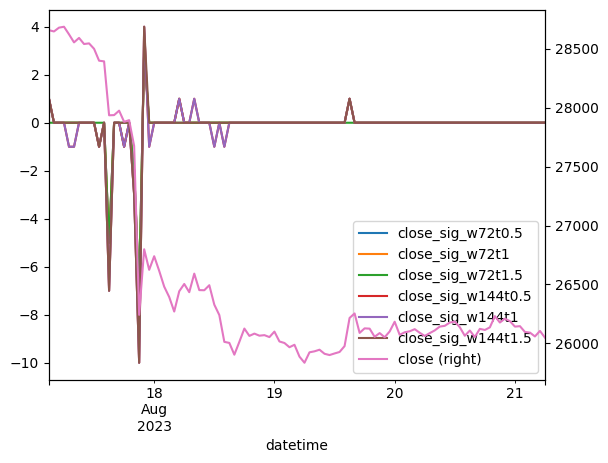

In [18]:
close_sigs = list(df1.filter(regex="close_sig").columns)
df1[close_sigs+["close"]].tail(100).plot(secondary_y = "close")

In [16]:
close_sigs

Index(['close_sig_w72t0.5', 'close_sig_w72t1', 'close_sig_w72t1.5',
       'close_sig_w144t0.5', 'close_sig_w144t1', 'close_sig_w144t1.5'],
      dtype='object')

## b) Tide_Z dynamic parameters tests